In [41]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import pandas as pd
from scipy import linalg as la
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from scipy.sparse import linalg as spla

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [20]:
ratings = pd.read_csv("ml-20m/ratings.csv",nrows=100000)

In [21]:
#Create variable "count" for number of ratings for each movie
ratings = ratings.merge(ratings.groupby("movieId").size().reset_index(name='count'), how='right', on='movieId')
#Drop any movies that have 17 or fewer ratings
ratings = ratings[ratings["count"]>17].sort_values(['userId', 'movieId'])
#Find the minimum number of movies reviewed by a user
reviews_per_user = ratings.groupby("userId").userId.apply(lambda x: len(x))
reviews_per_user.describe().min()

2.0

In [25]:
#Generate user-movie matrix with ratings as its values
user_c = CategoricalDtype(sorted(ratings.userId.unique()), ordered=True)
movie_c = CategoricalDtype(sorted(ratings.movieId.unique()), ordered=True)

row = ratings.userId.astype(user_c).cat.codes
col = ratings.movieId.astype(movie_c).cat.codes
sparse_matrix = csr_matrix((ratings['rating'], (row, col)), \
                           shape=(user_c.categories.size, movie_c.categories.size))

In [28]:
#Create sparse dataframe from user-movie matrix
dfs = pd.SparseDataFrame(sparse_matrix, \
                         index=user_c.categories, \
                         columns=movie_c.categories,default_fill_value=2.5)

In [38]:
def data_setup(user_id):
    """
    This function prepares our data for the train test split
    Inputs: 
    user_id
    Outputs:
    dfs 
    movies_not_seen
    movies_seen
    known_ratings
    """
    #get only those movies with more than 17 ratings (cutting out ~50% of movies)
    merged = r.merge(r.groupby("movieId").size().reset_index(name='count'),
                     how='right', on='movieId')
    df = merged[merged["count"]>17].sort_values(['userId', 'movieId'])
    
    #get our lucky user
    user1 = df[df.userId == user_id]

    df.drop(labels=df[df.userId == user_id].index, axis=0, inplace=True)
    
    #create a matrix from the ratings list
    user_c = CategoricalDtype(sorted(df.userId.unique()), ordered=True)
    movie_c = CategoricalDtype(sorted(df.movieId.unique()), ordered=True)
    row = df.userId.astype(user_c).cat.codes
    col = df.movieId.astype(movie_c).cat.codes
    
    #this matrix is movies x users
    sparse_matrix = csr_matrix((df['rating'], (row, col)), \
                               shape=(user_c.categories.size, movie_c.categories.size)).T
    
    #we can't deal with these NaN's, so we're lazy and just replace them all with 3's
    dfs = pd.SparseDataFrame(sparse_matrix, \
                         index=movie_c.categories, \
                         columns=user_c.categories, \
                         default_fill_value=3)
    
    #we can only train on the movies that the user has seen
    movies_seen = dfs.loc[user1.movieId.values].index.values
    movies_not_seen = list(set(dfs.index.values) - set(movies_seen))
    
    #turn user's rating into binary 'liked' (1) or 'disliked' (-1)
    known_ratings = user1.rating.values
    known_ratings[known_ratings <= 3] = -1 #right now the cutoff is 3. could also try 2.5?
    known_ratings[known_ratings > 3] = 1
    
    return dfs, movies_not_seen, movies_seen, known_ratings

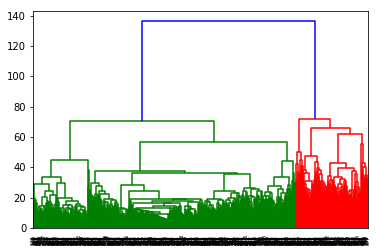

In [40]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(dfs, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'cosine', linkage = 'single')
# save clusters for chart
y_hc = hc.fit_predict(dfs)

In [45]:
User_id = 100
dfs, movies_not_seen, movies_seen, known_ratings = data_setup(User_id)
x_train, x_test, y_train, y_test = train_test_split(dfs.loc[movies_seen].values,known_ratings)

[-1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.] [0 0 2 0 2 2 0 0 3 0 0 1 0]
0.07692307692307693


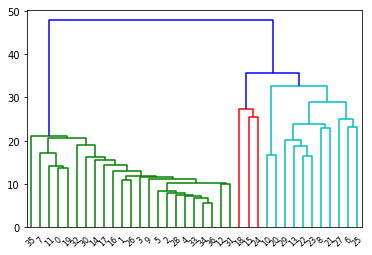

In [69]:
dendrogram = sch.dendrogram(sch.linkage(x_train, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(x_test)
print(y_test, y_hc)
print(accuracy_score(y_test,y_hc))


In [ ]:
users = 138493
accuracy = []
for user_id in range(1,users):
    dfs, movies_not_seen, movies_seen, known_ratings = data_setup(user_id)
    x_train, x_test, y_train, y_test = train_test_split(dfs.loc[movies_seen].values,known_ratings)
    endrogram = sch.dendrogram(sch.linkage(x_train, method='ward'))
    # create clusters
    hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
    # save clusters for chart
    y_hc = hc.fit_predict(x_test)
    accuracy.append(accuracy_score(y_test,y_hc))